# Text-to-Image Generation with ControlNet Conditioning

Diffusion models make a revolution in AI-generated art. This technology enables creation of high-quality images simply by writing a text prompt. Even though this technology gives very promising results, the diffusion process, in the first order, is the process of generating images from random noise and text conditions, which do not always clarify how desired content should look, which forms it should have and where it is located in relation to other objects on the image. Researchers have been looking for ways to have more control over the results of the generation process. ControlNet provides a minimal interface allowing users to customize the generation process to a great extent.

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) paper. It provides a framework that enables support for various spatial contexts such as a depth map, a segmentation map, a scribble, and key points that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

This notebook explores ControlNet in depth, especially a new technique for imparting high levels of control over the shape of synthesized images. It demonstrates how to run it, using OpenVINO. Let us get "controlling"!

## Background

### Stable Diffusion

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a text-to-image latent diffusion model created by researchers and engineers from CompVis, Stability AI, and LAION. 
Diffusion models as mentioned above can generate high-quality images. Stable Diffusion is based on a particular type of diffusion model called Latent Diffusion, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) paper. Generally speaking, diffusion models are machine learning systems that are trained to denoise random Gaussian noise step by step, to get to a sample of interest, such as an image. Diffusion models have been shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow because of its repeated, sequential nature. In addition, these models consume a lot of memory because they operate in pixel space, which becomes huge when generating high-resolution images. Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional latent space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: in latent diffusion, the model is trained to generate latent (compressed) representations of the images.

There are three main components in latent diffusion:

* A text-encoder, for example [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel) for creation condition to generate image from text prompt.
* A U-Net for step-by-step denoising latent image representation.
* An autoencoder (VAE) for encoding input image to latent space (if required) and decoding latent space to image back after generation.

For more details regarding Stable Diffusion work, refer to the [project website](https://ommer-lab.com/research/latent-diffusion-models/). There is a tutorial for Stable Diffusion Text-to-Image generation with OpenVINO, see the following [notebook](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb).

### ControlNet
ControlNet is a neural network structure to control diffusion models by adding extra conditions. Using this new framework, we can capture a scene, structure, object, or subject pose from an inputted image, and then transfer that quality to the generation process. In practice, this enables the model to completely retain the original input shape, and create a novel image that conserves the shape, pose, or outline while using the novel features from the inputted prompt.

![controlnet block](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/he.png)

Functionally, ControlNet operates by wrapping around an image synthesis process to impart attention to the shape required to operate the model using either its inbuilt prediction or one of many additional annotator models. Referring to the diagram above, we can see, on a rudimentary level, how ControlNet uses a trainable copy in conjunction with the original network to modify the final output with respect to the shape of the input control source.

By repeating the above simple structure 14 times, we can control stable diffusion in the following way:

![sd + controlnet](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/sd.png)

The input is simultaneously passed through the SD blocks, represented on the left, while simultaneously being processed by the ControlNet blocks on the right. This process is almost the same during encoding. When denoising the image, at each step the SD decoder blocks will receive control adjustments from the parallel processing path from ControlNet.

In the end, we are left with a very similar image synthesis pipeline with an additional control added for the shape of the output features in the final image.

Training ControlNet consists of the following steps:

1. Cloning the pre-trained parameters of a Diffusion model, such as Stable Diffusion's latent UNet, (referred to as “trainable copy”) while also maintaining the pre-trained parameters separately (”locked copy”). It is done so that the locked parameter copy can preserve the vast knowledge learned from a large dataset, whereas the trainable copy is employed to learn task-specific aspects.
2. The trainable and locked copies of the parameters are connected via “zero convolution” layers (see here for more information) which are optimized as a part of the ControlNet framework. This is a training trick to preserve the semantics already learned by a frozen model as the new conditions are trained.

The process of extracting specific information from the input image is called an annotation.
ControlNet comes pre-packaged with compatibility with several annotators-models that help it to identify the shape/form of the target in the image:

* Canny Edge Detection
* M-LSD Lines
* HED Boundary
* Scribbles
* Normal Map
* Human Pose Estimation
* Semantic Segmentation
* Depth Estimation

This tutorial focuses mainly on conditioning by pose. However, the discussed steps are also applicable to other annotation modes.

## Prerequisites

In [1]:
!pip install -q "diffusers==0.14.0" "controlnet-aux>=0.0.6" "gradio>=3.36"


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


## Instantiating Generation Pipeline

### ControlNet in Diffusers library

For working with Stable Diffusion and ControlNet models, we will use Hugging Face [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with ControlNet, Diffusers exposes the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). Central to the `StableDiffusionControlNetPipeline` is the `controlnet` argument which enables providing a particularly trained [`ControlNetModel`](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.ControlNetModel) instance while keeping the pre-trained diffusion model weights the same. The code below demonstrates how to create `StableDiffusionControlNetPipeline`, using the `controlnet-openpose` controlnet model and `stable-diffusion-v1-5`:

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float32)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet
)

2023-07-16 15:33:13.040077: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 15:33:13.079142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 15:33:13.688517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### OpenPose

Annotation is an important part of working with ControlNet.
[OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) is a fast keypoint detection model that can extract human poses like positions of hands, legs, and head. 
Below is the ControlNet workflow using OpenPose. Keypoints are extracted from the input image using OpenPose and saved as a control map containing the positions of keypoints. It is then fed to Stable Diffusion as an extra conditioning together with the text prompt. Images are generated based on these two conditionings.

![controlnet-openpose-pipe](https://user-images.githubusercontent.com/29454499/224248986-eedf6492-dd7a-402b-b65d-36de952094ec.png)

The code below demonstrates how to instantiate the OpenPose model.

In [3]:
from controlnet_aux import OpenposeDetector

pose_estimator = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Now, let us check its result on example image:

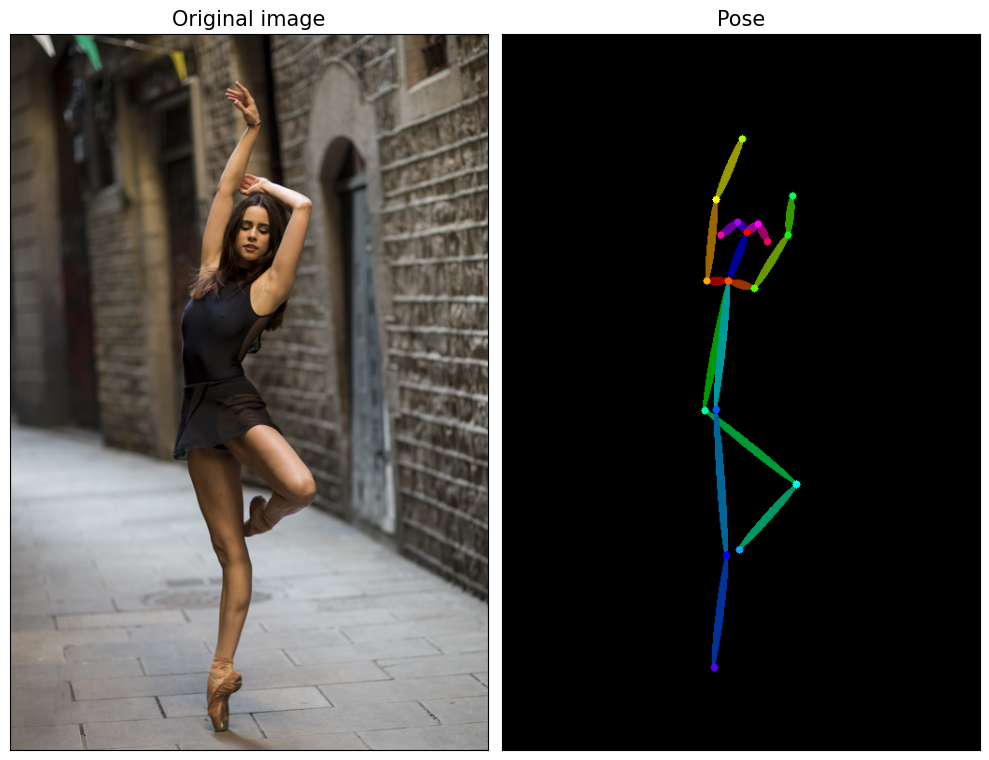

In [4]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


example_url = "https://user-images.githubusercontent.com/29454499/224540208-c172c92a-9714-4a7b-857a-b1e54b4d4791.jpg"
img = Image.open(requests.get(example_url, stream=True).raw)
pose = pose_estimator(img)


def visualize_pose_results(orig_img:Image.Image, skeleton_img:Image.Image):
    """
    Helper function for pose estimationresults visualization
    
    Parameters:
       orig_img (Image.Image): original image
       skeleton_img (Image.Image): processed image with body keypoints
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_img = orig_img.resize(skeleton_img.size)
    orig_title = "Original image"
    skeleton_title = "Pose"
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 10) if is_horizontal else (10, 20)
    fig, axs = plt.subplots(2 if is_horizontal else 1, 1 if is_horizontal else 2, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(skeleton_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(skeleton_title, fontsize=15) 
    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00 , hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    return fig


fig = visualize_pose_results(img, pose)

## Convert models to OpenVINO Intermediate representation (IR) format

OpenVINO supports PyTorch through export to the ONNX format. We will use the `torch.onnx.export` function for obtaining the ONNX model, 
we can learn more in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We need to provide a model object, input data for model tracing, and a path for saving the model. Optionally, we can provide a target ONNX opset for conversion and other parameters specified in the documentation (for example, input and output names or dynamic shapes).

While ONNX models are directly supported by OpenVINO™ runtime, it can be useful to convert them to IR format to take the advantage of advanced OpenVINO optimization tools and features. We will use [model conversion API](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to convert a model to IR format and compression weights to `FP16` format.


The pipeline consists of five important parts:

* OpenPose for obtaining annotation based on an estimated pose.
* ControlNet for conditioning by image annotation.
* Text Encoder for creation condition to generate an image from a text prompt.
* Unet for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### OpenPose conversion

OpenPose model is represented in the pipeline as a wrapper on the PyTorch model which not only detects poses on an input image but is also responsible for drawing pose maps. We need to convert only the pose estimation part, which is located inside the wrapper `pose_estimator.body_estimation.model`.

In [5]:
from pathlib import Path
import torch

OPENPOSE_ONNX_PATH = Path("openpose.onnx")
OPENPOSE_OV_PATH = OPENPOSE_ONNX_PATH.with_suffix(".xml")


if not OPENPOSE_OV_PATH.exists():
    if not OPENPOSE_ONNX_PATH.exists():
        torch.onnx.export(pose_estimator.body_estimation.model, torch.zeros([1, 3, 184, 136]), OPENPOSE_ONNX_PATH)
    !mo --input_model $OPENPOSE_ONNX_PATH --compress_to_fp16
    print('OpenPose successfully converted to IR')
else:
    print(f"OpenPose will be loaded from {OPENPOSE_OV_PATH}")

OpenPose will be loaded from openpose.xml


To reuse the original drawing procedure, we replace the PyTorch OpenPose model with the OpenVINO model, using the following code:

In [6]:
from openvino.runtime import Model, Core
from collections import namedtuple


class OpenPoseOVModel:
    """ Helper wrapper for OpenPose model inference"""
    def __init__(self, core, model_path, device="AUTO"):
        self.core = core
        self. model = core.read_model(model_path)
        self.compiled_model = core.compile_model(self.model, device)

    def __call__(self, input_tensor:torch.Tensor):
        """
        inference step
        
        Parameters:
          input_tensor (torch.Tensor): tensor with prerpcessed input image
        Returns:
           predicted keypoints heatmaps
        """
        h, w = input_tensor.shape[2:]
        input_shape = self.model.input(0).shape
        if h != input_shape[2] or w != input_shape[3]:
            self.reshape_model(h, w)
        results = self.compiled_model(input_tensor)
        return torch.from_numpy(results[self.compiled_model.output(0)]), torch.from_numpy(results[self.compiled_model.output(1)])

    def reshape_model(self, height:int, width:int):
        """
        helper method for reshaping model to fit input data
        
        Parameters:
          height (int): input tensor height
          width (int): input tensor width
        Returns:
          None
        """
        self.model.reshape({0: [1, 3, height, width]})
        self.compiled_model = self.core.compile_model(self.model)
        
    def parameters(self):
        Device = namedtuple("Device", ["device"])
        return [Device(torch.device("cpu"))]
    

 
core = Core()

## Select inference device

select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [8]:
ov_openpose = OpenPoseOVModel(core, OPENPOSE_OV_PATH, device=device.value)
pose_estimator.body_estimation.model = ov_openpose

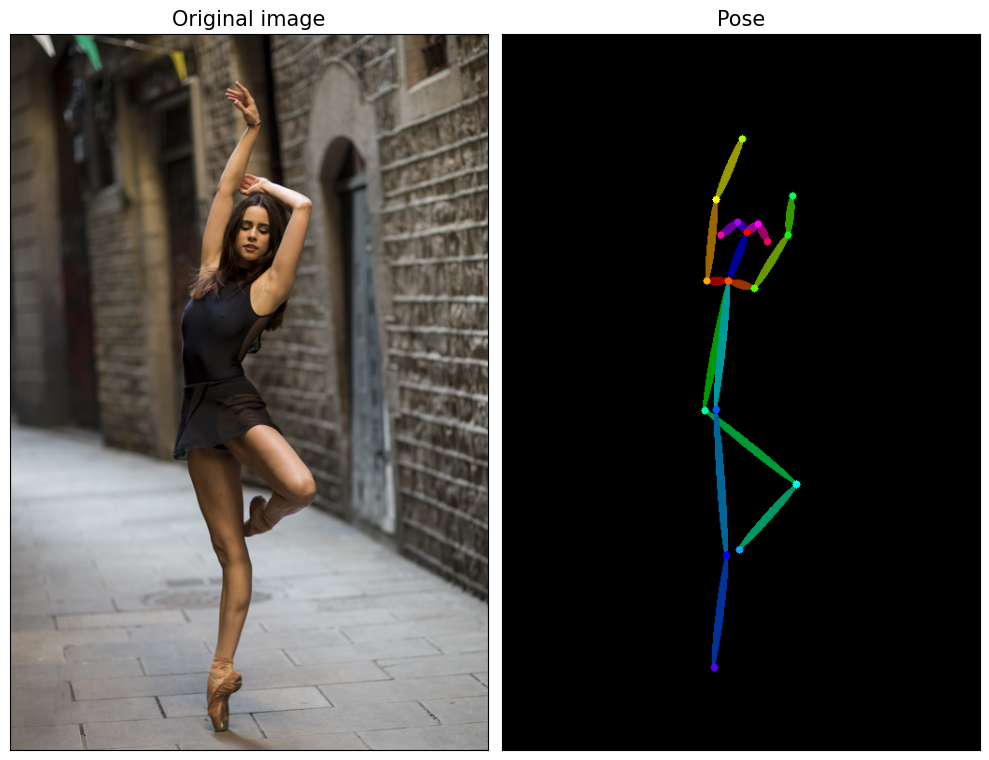

In [9]:
pose = pose_estimator(img)
fig = visualize_pose_results(img, pose)

Great! As we can see, it works perfectly.

### ControlNet conversion

The ControlNet model accepts the same inputs like UNet in Stable Diffusion pipeline and additional condition sample - skeleton key points map predicted by pose estimator:

* `sample` - latent image sample from the previous step, generation process has not been started yet, so we will use random noise,
* `timestep` - current scheduler step,
* `encoder_hidden_state` - hidden state of text encoder,
* `controlnet_cond` - condition input annotation.

The output of the model is attention hidden states from down and middle blocks, which serves additional context for the UNet model.

In [10]:
from torch.onnx import _export as torch_onnx_export
import gc

inputs = {
    "sample": torch.randn((2, 4, 64, 64)),
    "timestep": torch.tensor(1),
    "encoder_hidden_states": torch.randn((2,77,768)),
    "controlnet_cond": torch.randn((2,3,512,512))
}


CONTROLNET_ONNX_PATH = Path('controlnet-pose.onnx')
CONTROLNET_OV_PATH = CONTROLNET_ONNX_PATH.with_suffix('.xml')
controlnet.eval()
with torch.no_grad():
    down_block_res_samples, mid_block_res_sample = controlnet(**inputs, return_dict=False)

controlnet_output_names = [f"down_block_res_sample_{i}" for i in range(len(down_block_res_samples))]
controlnet_output_names.append("mid_block_res_sample")


if not CONTROLNET_OV_PATH.exists():
    if not CONTROLNET_ONNX_PATH.exists():

        with torch.no_grad():
            torch_onnx_export(controlnet, inputs, CONTROLNET_ONNX_PATH, input_names=list(inputs), output_names=controlnet_output_names, onnx_shape_inference=False)    
    !mo --input_model $CONTROLNET_ONNX_PATH --compress_to_fp16
    print('ControlNet successfully converted to IR')
else:
    print(f"ControlNet will be loaded from {CONTROLNET_OV_PATH}")

ControlNet will be loaded from controlnet-pose.xml


### UNet conversion

The process of UNet model conversion remains the same, like for original Stable Diffusion model, but with respect to the new inputs generated by ControlNet.

In [11]:
UNET_ONNX_PATH = Path('unet_controlnet/unet_controlnet.onnx')
UNET_OV_PATH = UNET_ONNX_PATH.parents[1] / 'unet_controlnet.xml'

if not UNET_OV_PATH.exists():
    if not UNET_ONNX_PATH.exists():
        UNET_ONNX_PATH.parent.mkdir(exist_ok=True)
        inputs.pop("controlnet_cond", None)
        inputs["down_block_additional_residuals"] = down_block_res_samples
        inputs["mid_block_additional_residual"] = mid_block_res_sample

        unet = pipe.unet
        unet.eval()

        input_names = ["sample", "timestep", "encoder_hidden_states", *controlnet_output_names]

        with torch.no_grad():
            torch_onnx_export(unet, inputs, str(UNET_ONNX_PATH), input_names=input_names, output_names=["sample_out"], onnx_shape_inference=False)
        del unet
    del pipe.unet
    gc.collect()
    !mo --input_model $UNET_ONNX_PATH --compress_to_fp16
    print('Unet successfully converted to IR')
else:
    del pipe.unet
    print(f"Unet will be loaded from {UNET_OV_PATH}")
gc.collect()

Unet will be loaded from unet_controlnet.xml


5513

### Text Encoder
The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

The input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by the tokenizer and padded to the maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states. We will use `opset_version=14` because the model contains the `triu` operation, supported in ONNX only starting from this opset.

In [12]:
TEXT_ENCODER_ONNX_PATH = Path('text_encoder.onnx')
TEXT_ENCODER_OV_PATH = TEXT_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_encoder_onnx(text_encoder:torch.nn.Module, onnx_path:Path):
    """
    Convert Text Encoder model to ONNX. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        input_ids = torch.ones((1, 77), dtype=torch.long)
        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            # infer model, just to make sure that it works
            text_encoder(input_ids)
            # export model to ONNX format
            torch_onnx_export(
                text_encoder,  # model instance
                input_ids,  # inputs for model tracing
                onnx_path,  # output file for saving result
                input_names=['tokens'],  # model input name for onnx representation
                output_names=['last_hidden_state', 'pooler_out'],  # model output names for onnx representation
                opset_version=14,  # onnx opset version for export
                onnx_shape_inference=False
            )
        print('Text Encoder successfully converted to ONNX')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder_onnx(pipe.text_encoder, TEXT_ENCODER_ONNX_PATH)
    !mo --input_model $TEXT_ENCODER_ONNX_PATH --compress_to_fp16
    print('Text Encoder successfully converted to IR')
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

gc.collect()

Text encoder will be loaded from text_encoder.xml


0

### VAE Decoder conversion

The VAE model has two parts, an encoder, and a decoder. The encoder is used to convert the image into a low-dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. During inference, we will see that we **only need the VAE decoder**. You can find instructions on how to convert the encoder part in a stable diffusion [notebook](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb).

In [13]:
VAE_DECODER_ONNX_PATH = Path('vae_decoder.onnx')
VAE_DECODER_OV_PATH = VAE_DECODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_decoder_onnx(vae: torch.nn.Module, onnx_path: Path):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        vae (torch.nn.Module): VAE model
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    if not onnx_path.exists():
        vae_decoder = VAEDecoderWrapper(vae)
        latents = torch.zeros((1, 4, 64, 64))

        vae_decoder.eval()
        with torch.no_grad():
            torch.onnx.export(vae_decoder, latents, onnx_path, input_names=[
                              'latents'], output_names=['sample'])
        print('VAE decoder successfully converted to ONNX')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder_onnx(pipe.vae, VAE_DECODER_ONNX_PATH)
    !mo --input_model $VAE_DECODER_ONNX_PATH --compress_to_fp16
    print('VAE decoder successfully converted to IR')
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

VAE decoder will be loaded from vae_decoder.xml


## Prepare Inference pipeline

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.
![detailed workflow](https://user-images.githubusercontent.com/29454499/224261720-2d20ca42-f139-47b7-b8b9-0b9f30e1ae1e.png)

The stable diffusion model takes both a latent seed and a text prompt as input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. In comparison with the original stable-diffusion pipeline, latent image representation, encoder hidden states, and control condition annotation passed via ControlNet on each denoising step for obtaining middle and down blocks attention parameters, these attention blocks results additionally will be provided to the UNet model for the control generation process. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

Theory on how the scheduler algorithm function works is out of scope for this notebook, but in short, you should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, it is recommended to look into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

In this tutorial, instead of using Stable Diffusion's default [`PNDMScheduler`](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm), we use one of the currently fastest diffusion model schedulers, called [`UniPCMultistepScheduler`](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc). Choosing an improved scheduler can drastically reduce inference time - in this case, we can reduce the number of inference steps from 50 to 20 while more or less keeping the same image generation quality. More information regarding schedulers can be found [here](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

The *denoising* process is repeated a given number of times (by default 50) to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto-encoder.

Similarly to Diffusers `StableDiffusionControlNetPipeline`, we define our own `OVContrlNetStableDiffusionPipeline` inference pipeline based on OpenVINO.

In [14]:
from diffusers.pipeline_utils import DiffusionPipeline
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import cv2


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height), resample=Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[np.dtype] = np.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type
    
    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (np.dtype, *optiona*, np.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = np.random.randn(*shape).astype(dtype)

    return latents


class OVContrlNetStableDiffusionPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for Stable Diffusion with ControlNet guidence
    """
    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler,
        core: Core,
        controlnet: Model,
        text_encoder: Model,
        unet: Model,
        vae_decoder: Model,
        device:str = "AUTO"
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, controlnet, text_encoder, unet, vae_decoder)
        self.set_progress_bar_config(disable=True)

    def load_models(self, core: Core, device: str, controlnet:Model, text_encoder: Model, unet: Model, vae_decoder: Model):
        """
        Function for loading models on device using OpenVINO
        
        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          controlnet (Model): OpenVINO Model object represents ControlNet
          text_encoder (Model): OpenVINO Model object represents text encoder
          unet (Model): OpenVINO Model object represents UNet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.text_encoder_out = self.text_encoder.output(0)
        self.controlnet = core.compile_model(controlnet, device)
        self.unet = core.compile_model(unet, device)
        self.unet_out = self.unet.output(0)
        self.vae_decoder = core.compile_model(vae_decoder)
        self.vae_decoder_out = self.vae_decoder.output(0)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: Image.Image,
        num_inference_steps: int = 10,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: float = 7.5,
        controlnet_conditioning_scale: float = 1.0,
        eta: float = 0.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (`str` or `List[str]`):
                negative prompt or prompts for generation
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            latents (`np.ndarray`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, Image.Image]]): generaited images
            
        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt, negative_prompt=negative_prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image)
        height, width = image.shape[-2:]
        if do_classifier_free_guidance:
            image = np.concatenate(([image] * 2))

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 6. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            latents,
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate(
                    [latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                result = self.controlnet([latent_model_input, t, text_embeddings, image])
                down_and_mid_blok_samples = [sample * controlnet_conditioning_scale for _, sample in result.items()]

                # predict the noise residual
                noise_pred = self.unet([latent_model_input, t, text_embeddings, *down_and_mid_blok_samples])[self.unet_out]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()

                # update progress
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        # 8. Post-processing
        image = self.decode_latents(latents, pad)

        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height), Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width))
                     for img in image]

        return image

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self.text_encoder_out]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self.text_encoder_out]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings

    def prepare_latents(self, batch_size:int, num_channels_latents:int, height:int, width:int, dtype:np.dtype = np.float32, latents:np.ndarray = None):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly, 
        then prepared latents scaled by the standard deviation required by the scheduler
        
        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def decode_latents(self, latents:np.array, pad:Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result
        
        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[self.vae_decoder_out]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

/tmp/ipykernel_1180132/670611772.py:1: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_utils instead.
  from diffusers.pipeline_utils import DiffusionPipeline


In [15]:
from transformers import CLIPTokenizer
from diffusers import UniPCMultistepScheduler

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


def visualize_results(orig_img:Image.Image, skeleton_img:Image.Image, result_img:Image.Image):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (Image.Image): original image
       skeleton_img (Image.Image): image with body pose keypoints
       result_img (Image.Image): generated image
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "Original image"
    skeleton_title = "Pose"
    orig_img = orig_img.resize(result_img.size)
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 20)
    fig, axs = plt.subplots(3 if is_horizontal else 1, 1 if is_horizontal else 3, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(skeleton_img))
    list_axes[2].imshow(np.array(result_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(skeleton_title, fontsize=15) 
    list_axes[2].set_title("Result", fontsize=15)
    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00 , hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    fig.savefig("result.png", bbox_inches='tight')
    return fig

## Running Text-to-Image Generation with ControlNet Conditioning and OpenVINO

Now, we are ready to start generation. For improving the generation process, we also introduce an opportunity to provide a `negative prompt`. Technically, positive prompt steers the diffusion toward the images associated with it, while negative prompt steers the diffusion away from it. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). We can keep this field empty if we want to generate image without negative prompting.

## Select inference device

select device from dropdown list for running inference using OpenVINO

In [16]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [17]:
ov_pipe = OVContrlNetStableDiffusionPipeline(tokenizer, scheduler, core, CONTROLNET_OV_PATH, TEXT_ENCODER_OV_PATH, UNET_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)

In [18]:
import gradio as gr
from urllib.request import urlretrieve

urlretrieve(example_url, "example.jpg")
gr.close_all()
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            inp_img = gr.Image(label="Input image")
            pose_btn = gr.Button("Extract pose")
            examples = gr.Examples(["example.jpg"], inp_img)
        with gr.Column(visible=False) as step1:
            out_pose = gr.Image(label="Estimated pose", type='pil')
            inp_prompt = gr.Textbox(
                "Dancing Darth Vader, best quality, extremely detailed", label="Prompt"
            )
            inp_neg_prompt = gr.Textbox(
                "monochrome, lowres, bad anatomy, worst quality, low quality",
                label="Negative prompt",
            )
            inp_seed = gr.Slider(label="Seed", value=42, maximum=1024000000)
            inp_steps = gr.Slider(label="Steps", value=20, minimum=1, maximum=50)
            btn = gr.Button()
        with gr.Column(visible=False) as step2:
            out_result = gr.Image(label="Result")

    def extract_pose(img):
        if img is None:
            raise gr.Error("Please upload the image or use one from the examples list")
        return {step1: gr.update(visible=True), step2: gr.update(visible=True), out_pose: pose_estimator(img)}

    def generate(pose, prompt, negative_prompt, seed, num_steps, progress=gr.Progress(track_tqdm=True)):
        np.random.seed(seed)
        result = ov_pipe(prompt, pose, num_steps, negative_prompt)[0]
        return result

    pose_btn.click(extract_pose, inp_img, [out_pose, step1, step2])
    btn.click(generate, [out_pose, inp_prompt, inp_neg_prompt, inp_seed, inp_steps], out_result)

demo.queue().launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6927b0a05729fd4297.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
